## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

In [7]:
# gpu
torch.cuda.is_available()

True

In [8]:
# global parameter
DATA_DIR="../dlwpt-code/data/"

## data

In [9]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

In [10]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [11]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

## nn module

In [12]:
linear_model=nn.Linear(1,1)
linear_model(t_un_val)

tensor([[2.6615],
        [2.7592]], grad_fn=<AddmmBackward>)

In [13]:
linear_model.weight,linear_model.bias

(Parameter containing:
 tensor([[0.5145]], requires_grad=True),
 Parameter containing:
 tensor([-0.2349], requires_grad=True))

## training

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 309.8432, Validation loss 307.5520
Epoch 1000, Training loss 3.5557, Validation loss 2.5746
Epoch 2000, Training loss 3.0435, Validation loss 2.5046
Epoch 3000, Training loss 3.0355, Validation loss 2.4961


## sequential

In [16]:
seq_model=nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)

In [18]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 168.9162, Validation loss 144.8930
Epoch 1000, Training loss 4.0642, Validation loss 2.6756
Epoch 2000, Training loss 2.3072, Validation loss 2.0489
Epoch 3000, Training loss 2.3261, Validation loss 2.5605


In [27]:
x=torch.tensor(np.linspace(20,90,100)).unsqueeze(1).float()
y=seq_model(0.1*x)

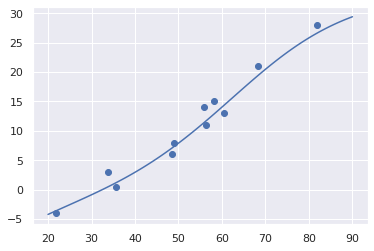

In [29]:
plt.scatter(t_u,t_c);
plt.plot(x,y.detach().numpy())